# CA YOUTH PAROLE

In [74]:
"""
STATE: CA
POLICY: Youth Parole for Life-With-Parole Clients
VERSION: V1
DATA SOURCE: CDCR
DATA QUALITY: good
HIGHEST PRIORITY MISSING DATA: N/A
REFERENCE_DATE: October 2022
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display
import itertools


%run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_seq_items", None)
pd.set_option("display.width", None)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 3600x2100 with 0 Axes>

In [75]:
import sys

sys.path.insert(1, "/Users/jazz/Recidiviz/pulse-data")

In [76]:
from recidiviz.calculator.modeling.population_projection.super_simulation.time_converter import (
    TimeConverter,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import (
    convert_dates,
)
from recidiviz.utils.yaml_dict import YAMLDict

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

In [77]:
# CA_DIRECTORY_PATH = "recidiviz/calculator/modeling/population_projection/state/CA/youth_parole"

# Get the simulation tag from the model inputs config
yaml_file_path = "ca_youth_parole_model_inputs.yaml"

simulation_config = YAMLDict.from_path(yaml_file_path)
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

# Convert the timestamps to time_steps (relative ints), with 0 being the most recent
# date of data (Sept. 2020)
reference_date = simulation_config.pop("reference_date", float)
time_step = simulation_config.pop("time_step", float)
time_converter = TimeConverter(reference_year=reference_date, time_step=time_step)

# Data setup

In [78]:
day_of_data = pd.to_datetime("2022-10-31")
ca_full = pd.read_csv("C006035_2022_10_31.csv")
ca = ca_full

In [79]:
ca["time_served_months"] = ca["Time Served (Months)"]
ca["time_served_years"] = ca.time_served_months / 12

# Calculate prison start date using Time Served field relative to snapshot date
ca["start_date_calc"] = day_of_data - pd.to_timedelta(
    ca.time_served_months * 30.4167, "d"
)

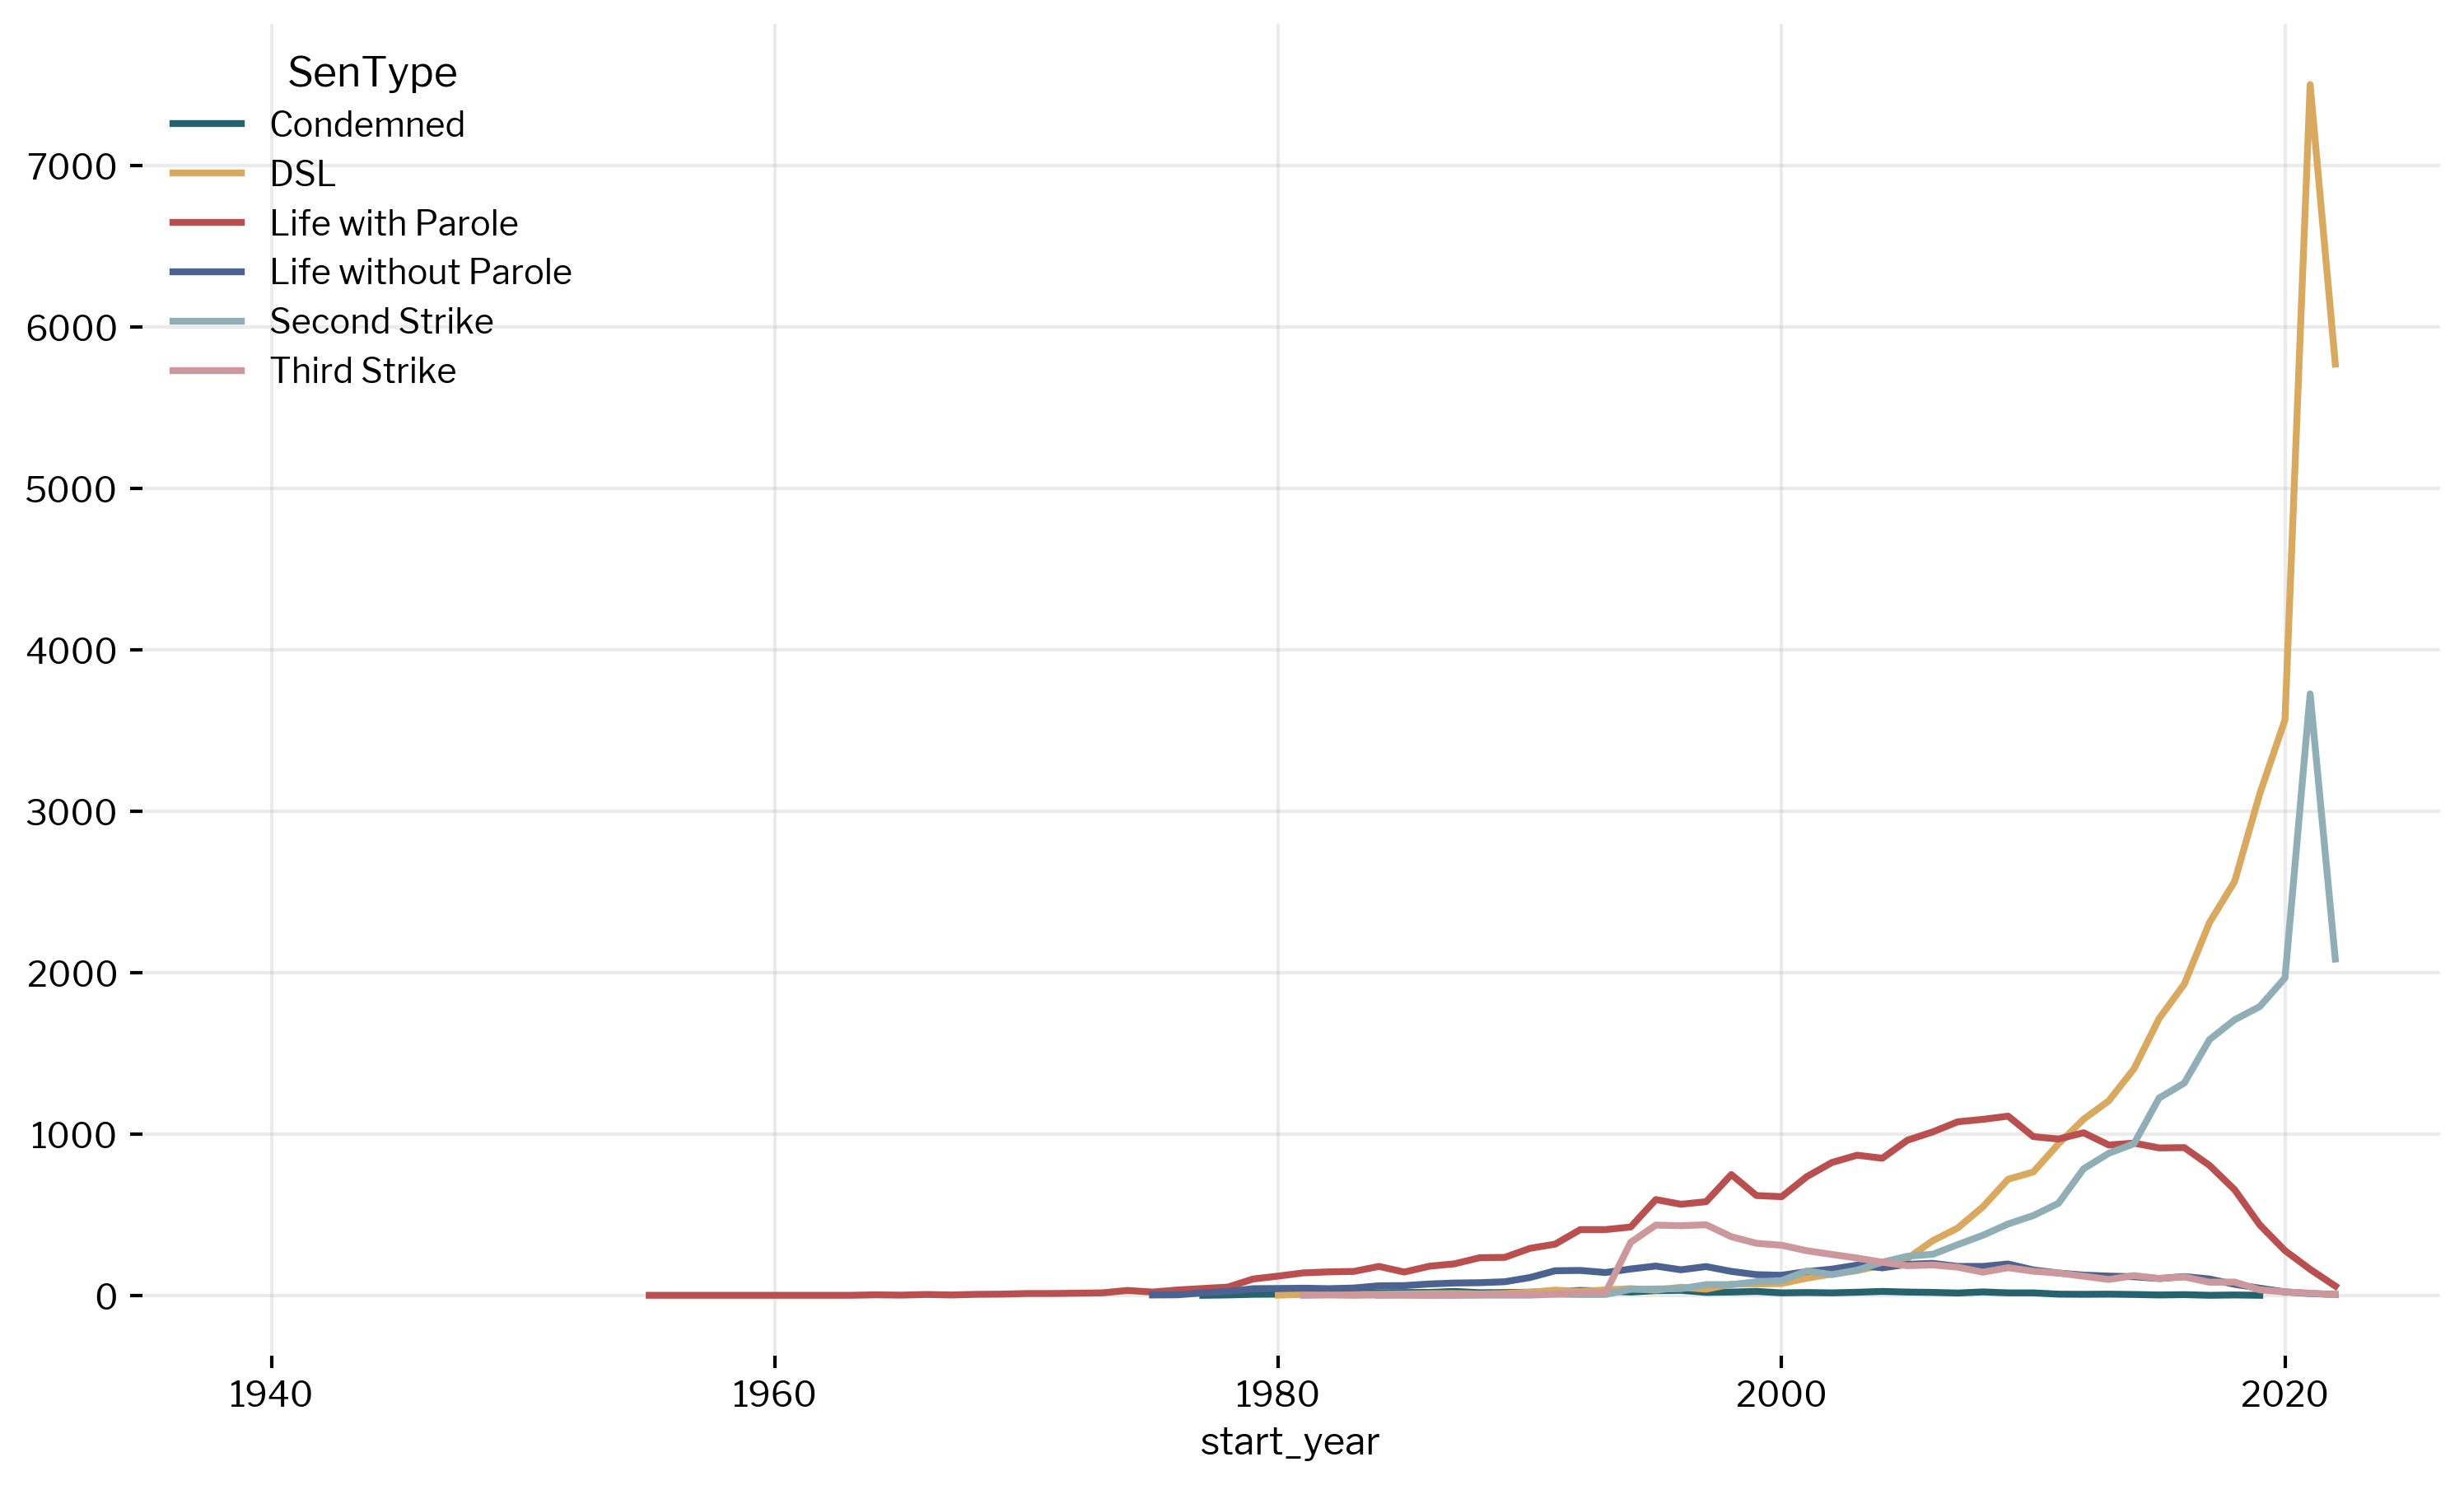

In [80]:
ca["start_year"] = ca.start_date_calc.dt.year
(
    ca.groupby(["start_year", "SenType"])[["ID"]]
    .count()
    .reset_index()
    .pivot(index="start_year", columns="SenType", values="ID")
    .plot()
)
ca = ca.drop(labels=["start_year"], axis=1)

In [81]:
# Limit eligible group
ca = ca.loc[ca.SenType == "Life with Parole"]
ca = ca.loc[ca["Offense Age"] < 26]
# ca = ca.loc[~ca["Offense Group"].str.contains("Murder 1st")]

In [82]:
ca.head()

,ID,SenType,Minimum,Maximum,ReleaseType,Offense Group,Race,Ethnicity,Gender,Age,Offense Age,Time Served (Months),Revocation (Y/N),Housing Program,Disability Placement Program,Time Period,time_served_months,time_served_years,start_date_calc
5,254,Life with Parole,54Y 4M,Life w/ Parole,MEPD,Other Assault/Battery,White,White,Female,55,23,342.2,No,General Population,NaN,1990-06-06 - 9999-12-31,342.2,28.516667,1994-05-02 09:43:34.464000000
36,6302,Life with Parole,7Y 0M,Life w/ Parole,MEPD,Murder 1st,White,White,Female,73,19,630.9,No,General Population,NaN,1000-01-01 - 1978-11-07,630.9,52.575000,1970-04-17 02:29:43.008000000
84,14552,Life with Parole,12Y 0M,Life w/ Parole,MEPD,Other Assault/Battery,Black,Black,Female,50,18,371.4,No,General Population,NaN,1990-01-01 - 9999-12-31,371.4,30.950000,1991-11-26 05:42:10.368000001
90,15698,Life with Parole,58Y 0M,Life w/ Parole,MEPD,Murder 1st,Mexican,Mexican,Female,49,25,278.2,No,General Population,NaN,1979-01-01 - 9999-12-31,278.2,23.183333,1999-08-31 01:46:38.784000000
188,26038,Life with Parole,80Y 0M,Life w/ Parole,MEPD,Murder 1st,Hispanic,Hispanic,Female,35,25,119.9,No,General Population,NaN,1979-01-01 - 9999-12-31,119.9,9.991667,2012-11-05 00:54:14.688000000


In [83]:
ca[["minimum_years", "minimum_months"]] = ca.Minimum.str.extract(
    r"(\d*)Y\s(\d*)M", expand=True
)
ca["minimum_sentence_years"] = ca.minimum_years.astype(float) + (
    ca.minimum_months.astype(float) / 12
)
ca = ca.drop(labels=["minimum_years", "minimum_months"], axis=1)

In [84]:
policy_parole_years = 14
policy_date = pd.to_datetime("2023-07-01")

In [85]:
def get_parole_eligibility_years(x):
    if x.minimum_sentence_years >= 25:
        return 25
    else:
        return 20

In [86]:
ca["parole_eligibility_years"] = ca.apply(
    lambda x: get_parole_eligibility_years(x), axis=1
)
ca["parole_eligibility_date"] = ca.start_date_calc + pd.to_timedelta(
    ca.parole_eligibility_years * 365.25, "d"
)
ca["parole_eligibility_date_policy"] = ca.start_date_calc + pd.to_timedelta(
    policy_parole_years * 365.25, "d"
)

In [87]:
# Further limit eligible group to those with a new parole date
ca = ca.loc[ca.minimum_sentence_years > policy_parole_years]
ca = ca.loc[ca.parole_eligibility_date > policy_date]

# Sessions

In [88]:
# TEMP: simplification - immediate hearing AND release
ca["outflow_date_control"] = ca.parole_eligibility_date
# ca["outflow_date_policy"] = ca.parole_eligibility_date_policy

In [89]:
hearing_success_rate = 0.17
flows = pd.DataFrame(
    {
        "outflow_to": ["parole", "prison"],
        "percent_outflow": [hearing_success_rate, 1 - hearing_success_rate],
    }
)
flows

,outflow_to,percent_outflow
0,parole,0.17
1,prison,0.83


In [90]:
cas = pd.merge(ca, flows, how="cross")

In [91]:
cas["prison_los_control"] = np.round(
    (cas.outflow_date_control - cas.start_date_calc).dt.days / 30.4167
).astype(float)

In [92]:
# cas["prison_los_policy"] = np.round(
#     (cas.outflow_date_policy - cas.start_date_calc).dt.days / 30.4167
# ).astype(float)

In [93]:
cas["time_step"] = convert_dates(time_converter, cas.start_date_calc)
cas["time_step_end_control"] = convert_dates(time_converter, cas.outflow_date_control)
cas["compartment"] = "prison"
cas["crime_type"] = cas.parole_eligibility_years.astype(str)

# Transition table

In [94]:
disaggregation_axes = ["crime_type"]

In [95]:
def get_transitions_table(sessions, los_field):
    transitions = sessions.groupby(
        disaggregation_axes + ["compartment", "outflow_to", los_field]
    ).percent_outflow.sum()

    transitions = transitions.reset_index().rename(
        columns={
            los_field: "compartment_duration",
            "percent_outflow": "total_population",
        }
    )

    un = [transitions[d].unique() for d in disaggregation_axes]
    manual_combos = list(itertools.product(*un))
    min_transitions_per_compartment = len(manual_combos)

    manual_transitions = pd.DataFrame(manual_combos, columns=disaggregation_axes)
    manual_transitions["compartment"] = "parole"
    manual_transitions["outflow_to"] = "parole"
    manual_transitions["total_population"] = 1
    manual_transitions["compartment_duration"] = 1

    transitions = pd.concat([transitions, manual_transitions])
    return transitions

In [96]:
transitions_control = get_transitions_table(cas, "prison_los_control")
# transitions_policy = get_transitions_table(cas, "prison_los_policy")

In [97]:
transitions_control

,crime_type,compartment,outflow_to,compartment_duration,total_population
0,20,prison,parole,240.0,204.17
1,20,prison,prison,240.0,996.83
2,25,prison,parole,300.0,1185.58
3,25,prison,prison,300.0,5788.42
0,20,parole,parole,1.0,1.00
1,25,parole,parole,1.0,1.00


# Total population

In [98]:
def get_total_population(sessions, session_start_field, session_end_field):
    total_population_start_ts = -600
    total_population = pd.DataFrame()
    for time_step in range(total_population_start_ts, 1):
        active_population = sessions[
            (sessions[session_start_field] <= time_step)
            & (time_step < sessions[session_end_field])
        ]
        active_population = (
            active_population.groupby(disaggregation_axes + ["compartment"])
            .percent_outflow.sum()
            .reset_index()
        )

        active_population[session_start_field] = time_step
        total_population = pd.concat([total_population, active_population])

    total_population.rename(
        columns={"percent_outflow": "total_population"},
        inplace=True,
    )
    return total_population  # [total_population.time_step >= -60]

In [99]:
total_population = get_total_population(cas, "time_step", "time_step_end_control")

In [100]:
total_population.tail()

,crime_type,compartment,total_population,time_step
1,25,prison,6974.0,-2
0,20,prison,1201.0,-1
1,25,prison,6974.0,-1
0,20,prison,1201.0,0
1,25,prison,6974.0,0


<AxesSubplot: xlabel='time_step'>

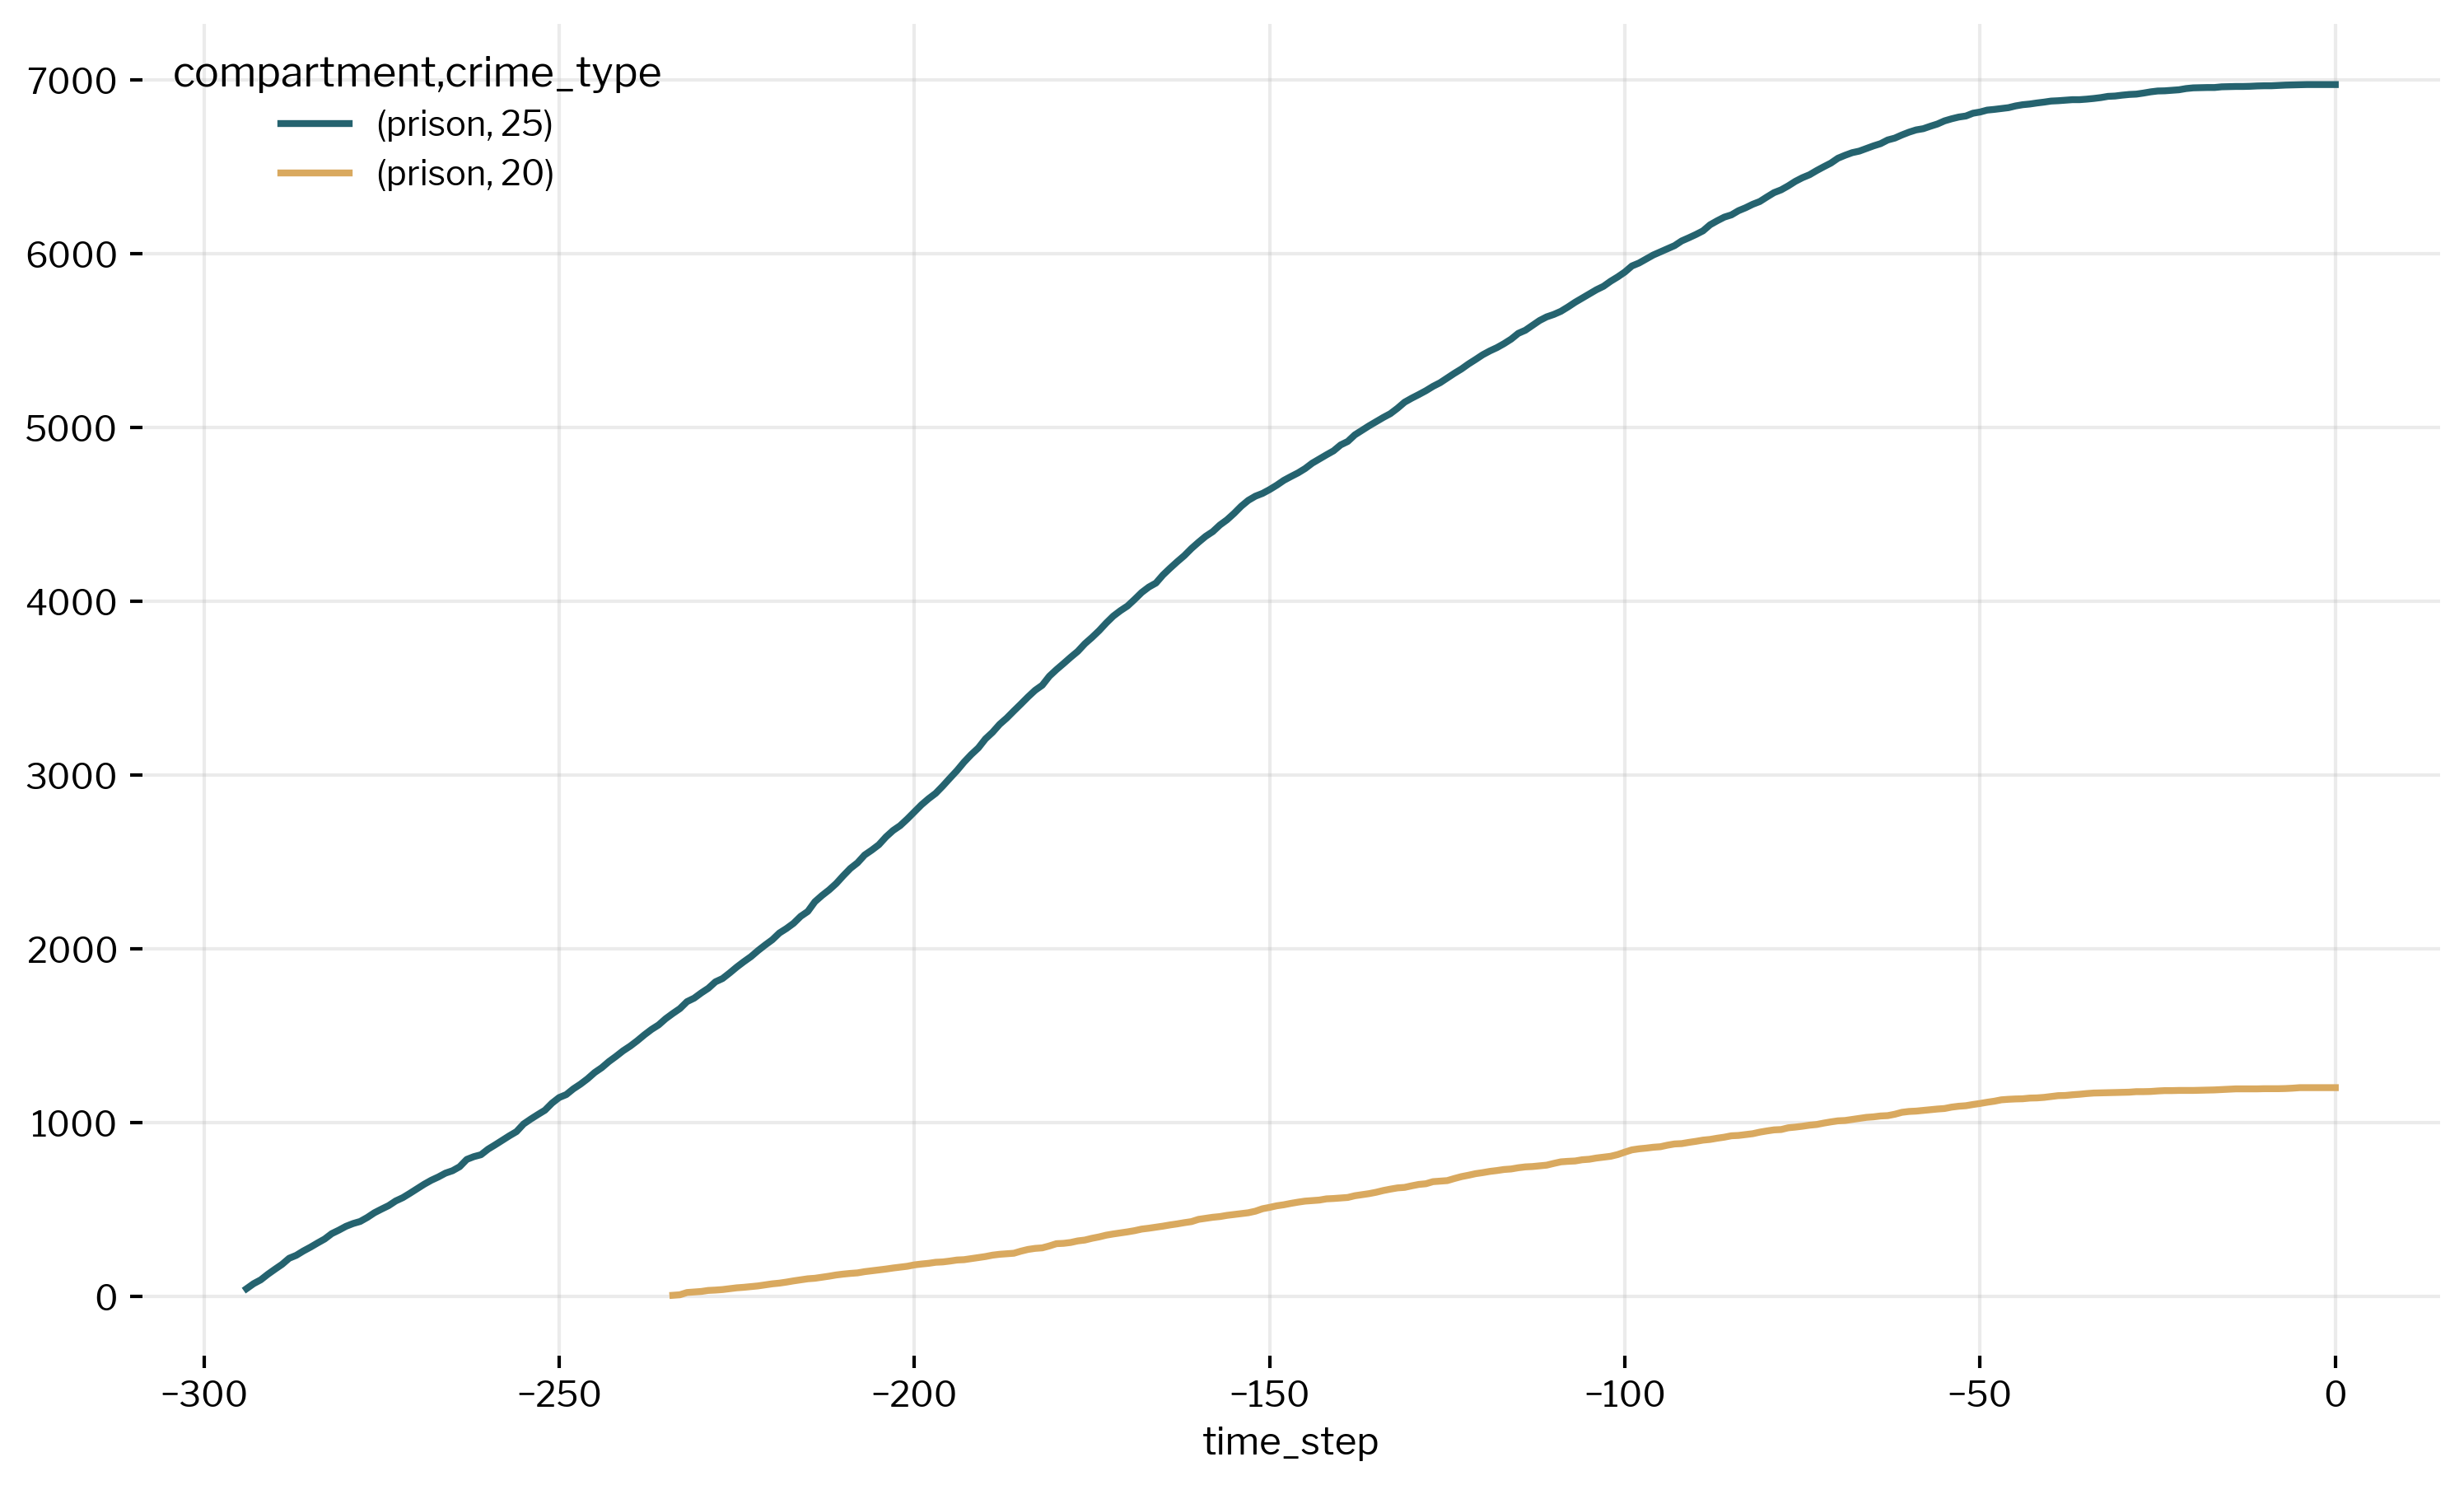

In [101]:
total_population.groupby(["time_step", "compartment", "crime_type"])[
    ["total_population"]
].sum().reset_index().pivot(
    index="time_step",
    columns=["compartment", "crime_type"],
    values="total_population",
)[
    ["prison"]
].plot()

# Outflows

In [102]:
disaggregation_axes = ["crime_type"]

In [109]:
# group by disagg and sentence start month
monthly_admissions_data = (
    cas[(cas.time_step <= 0) & (cas.time_step >= -600)]
    .groupby(disaggregation_axes + ["time_step"])[["ID"]]
    .nunique()
    .astype("float64")
    .rename(columns={"ID": "total_population"})
)
monthly_admissions_data["compartment"] = "pretrial"
monthly_admissions_data["outflow_to"] = "prison"

NameError: name 'sessions' is not defined

In [104]:
outflows = monthly_admissions_data.reset_index()
outflows.head()

,crime_type,time_step,total_population,compartment,outflow_to
0,20,-234,6.0,pretrial,prison
1,20,-233,3.0,pretrial,prison
2,20,-232,13.0,pretrial,prison
3,20,-231,3.0,pretrial,prison
4,20,-230,3.0,pretrial,prison


In [105]:
outflows.tail(12)

,crime_type,time_step,total_population,compartment,outflow_to
496,25,-18,1.0,pretrial,prison
497,25,-16,4.0,pretrial,prison
498,25,-15,1.0,pretrial,prison
499,25,-14,1.0,pretrial,prison
500,25,-12,1.0,pretrial,prison
501,25,-11,2.0,pretrial,prison
502,25,-10,1.0,pretrial,prison
503,25,-8,2.0,pretrial,prison
504,25,-7,2.0,pretrial,prison
505,25,-6,1.0,pretrial,prison


<AxesSubplot: xlabel='time_step'>

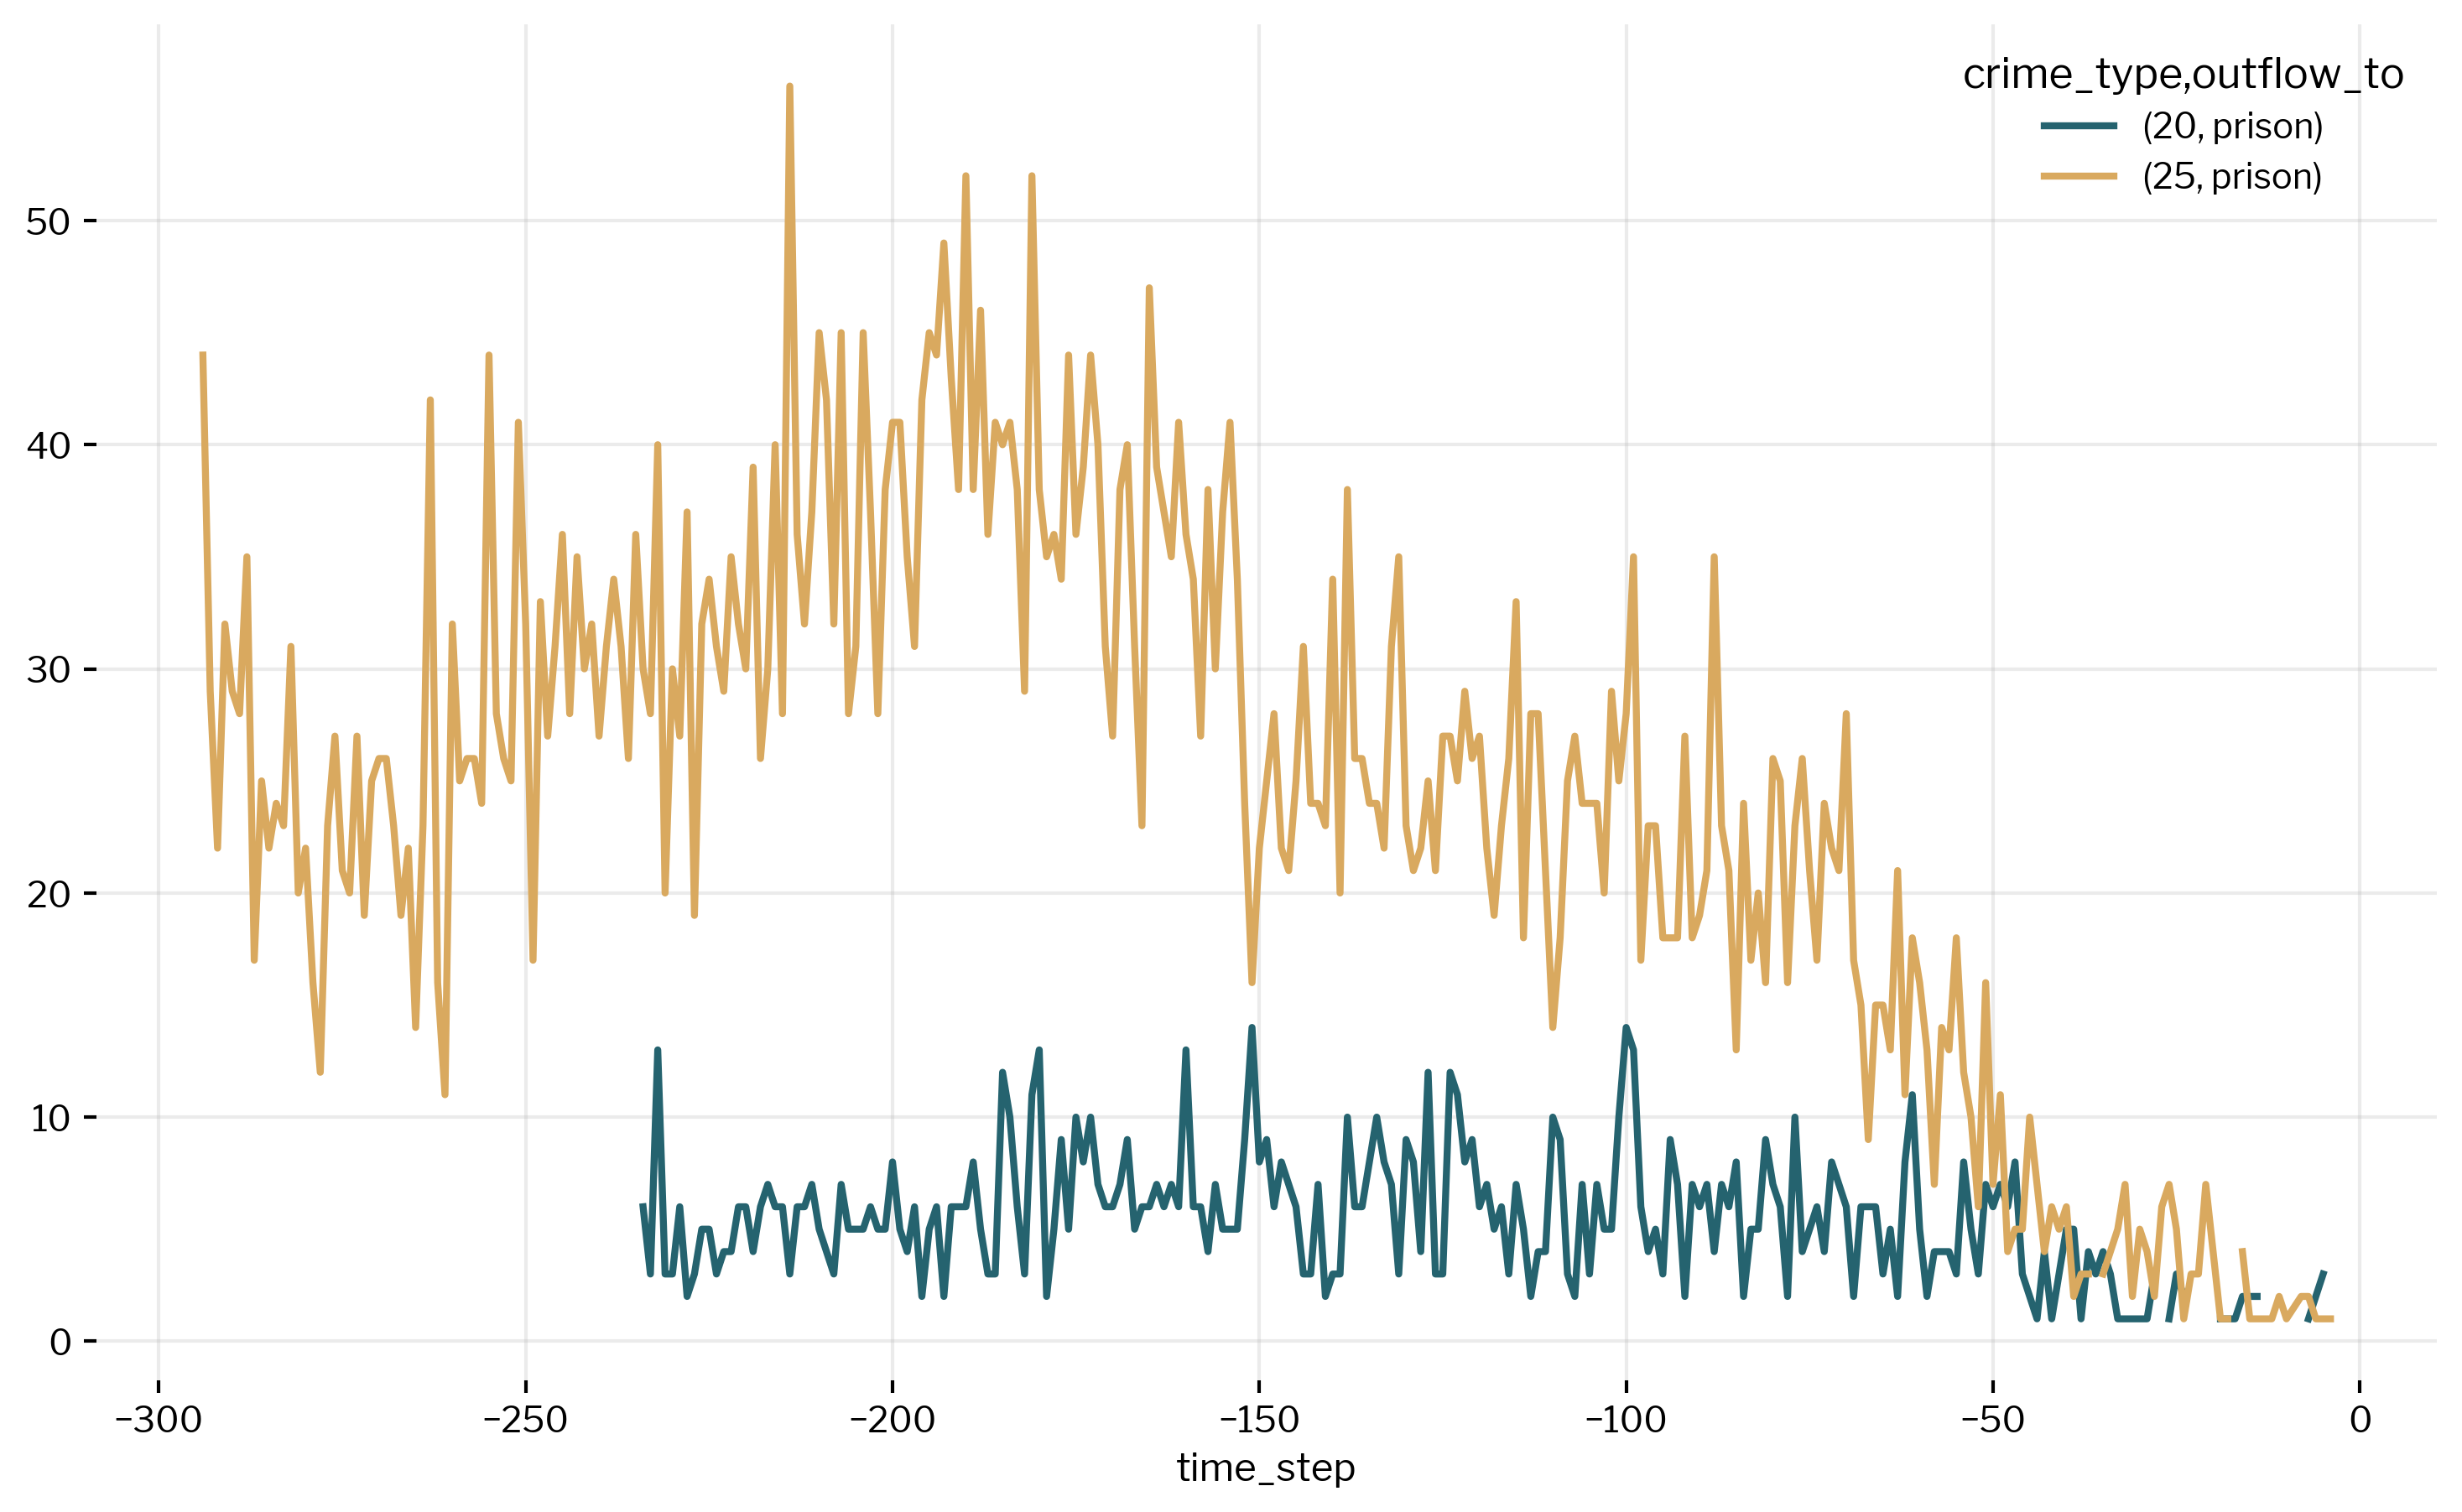

In [106]:
monthly_admissions_data.reset_index().pivot(
    index="time_step",
    columns=disaggregation_axes + ["outflow_to"],
    values="total_population",
).plot()

In [107]:
simulation_tag

'ca_youth_parole_2023'

In [ ]:
upload_spark_model_inputs(
    project_id="recidiviz-staging",
    simulation_tag=simulation_tag,
    outflows_data_df=outflows,
    transitions_data_df=transitions_control,
    total_population_data_df=total_population,
    yaml_path=yaml_file_path,
)